# Field correlations

*last updated February 28th, 2026 by Kevin Anchukaitis to improve time handling and clarify Markdown desscriptions*

This notebook contains an example of using xarray for field correlations (the correlation of one time series against the time series data from every point in a field).  In doing so, some of the difficulty in wrestling with different calendar systems and getting our data into a form that allows us to use the xarray correlation function (`xr.corr`) is also demonstrated.

First we import our packages:

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features


We're going to read in a monthly time series of the [Southern Oscillation Index (SOI)](https://www.ncei.noaa.gov/access/monitoring/enso/soi), a standardized index measuring the sea level pressure (SLP) difference between Tahiti and Darwin, Australia.  As such, it reflects 'large-scale fluctuations in air pressure between the western and eastern tropical Pacific'.  When the SOI is in a negative phase, there is below normal SLP at Tahiti and above normal SLP at Darwin, indicating coupled atmosphere-ocean conditions associated with El Nino and anomalously warm water in the central and eastern tropical Pacific.  Positive SOI values are associated with La Nina events.  The SOI therefore reflects the tropical atmospheric component of ENSO.  This version of the index comes from the Climate Research Unit at the University of East Anglia (you can see more here: https://crudata.uea.ac.uk/cru/data/soi/).

Unfortunately, the time coordinate in this file uses 'months since' units with a Gregorian calendar.  The problem is that 'months' is an ambigious unit of time (how many days are in a month? The answer is 'it depends').  Furthermore, `cftime` — the library that xarray can use to decode various non-standard time units — only supports 'months since' for a 360-day calendars, where every month is exactly 30 days (something that some climate modeling groups do). For a normal Gregorian calendar, months have different lengths (and February varies by year). This is a giant pain. We are therefore going to have to build the time coordinate manually.

Why don't I just fix it for you, or get a different file?  It is worth seeing how to deal with this, because unfortunately for a lot of datasets, this isn't an uncommon unit of time. 

The key to making this easy is using `freq='MS'` (month start) in Panda's `pd.date_range`, which produces properly formatted dates anchored to the 1st of each month. We then use `assign_coords` to attach the new coordinate to the DataArray.  There are more complicated ways to do this (trust me!), but this is fairly straightforward and transparent.

In [4]:
# get the SOI dataset but don't automatically decode the time units
soi_ds = xr.open_dataset("soi.nc", decode_times=False)
soi_ds


<xarray.Dataset> Size: 15kB
Dimensions:  (time: 1896)
Coordinates:
  * time     (time) float32 8kB 0.0 1.0 2.0 ... 1.893e+03 1.894e+03 1.895e+03
Data variables:
    SOI      (time) float32 8kB ...
Attributes:
    title:        
    description:  SOI
    scripturl01:  http://climexp.knmi.nl/getindices.cgi?STATION=SOI&TYPE=i&WM...
    institution:  KNMI Climate Explorer and UAE/CRU
    author:       Tim Osborn and Phil Jones
    reference:    Ropelewski, C.F. and Jones, P.D., 1987: An extension of the...
    link:         https://crudata.uea.ac.uk/cru/data/soi/
    source:       http://www.cru.uea.ac.uk/cru/data/soi/soi.dat
    comment:      
    scripturl02:  http://climexp.knmi.nl/dat2nc.cgi?id=someone@somewhere&stat...
    history:       2023-10-16 22:31:57 ./bin/dat2nc data/isoi.dat i SOI data/...
    Conventions:  CF-1.0

As you can see, `soi_ds` is a DataSet with a time coordinate that isn't super useful.  Let's create the new time coordinate and extract the SOI series as a DataArray:

In [5]:

# Build the time coordinate manually instead using pd.date_range with freq='MS' 
# We create a range of dates starting with the first year and month of the dataset for as long as there are (monthly) values:
new_time = pd.date_range(start='1866-01', periods=len(soi_ds["time"]), freq='MS')

## note that I manually entered the start year and month above - turns out we could automatically extract this from the 'months since' units: 
# units = soi_ds["time"].attrs["units"]  # this returns 'months since 1866-01-15' as a string
# startdate = units.split("since")[1].strip()  # this then splits that string and keeps the part with the starting date '1866-01-15'

# assign_coords replaces the time coordinate while we extract the DataArray
soi = soi_ds["SOI"].assign_coords(time=new_time)
soi

<xarray.DataArray 'SOI' (time: 1896)> Size: 8kB
[1896 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 15kB 1866-01-01 1866-02-01 ... 2023-12-01
Attributes:
    long_name:  CRU Southern Oscillation Index
    units:      1

Let's get a December-February 3 month mean for each year.  Boreal winter is the time where ENSO events canonically peak, so using this season allows us to characterize the mature phase on an El Nino or La Nina event.  Similar to what we did in Homework #2, we'll take every 3 month average than ends in February to give us DJF averages with the year assigned to the year of the the February. 

Note that instead of how I did this in Homework #2, we're going to use an xarray argument `min_periods`, which will automatically require 3 months from the data to make the DJF mean (e.g. this now automatically dones't create a DJF for a year with no December values):

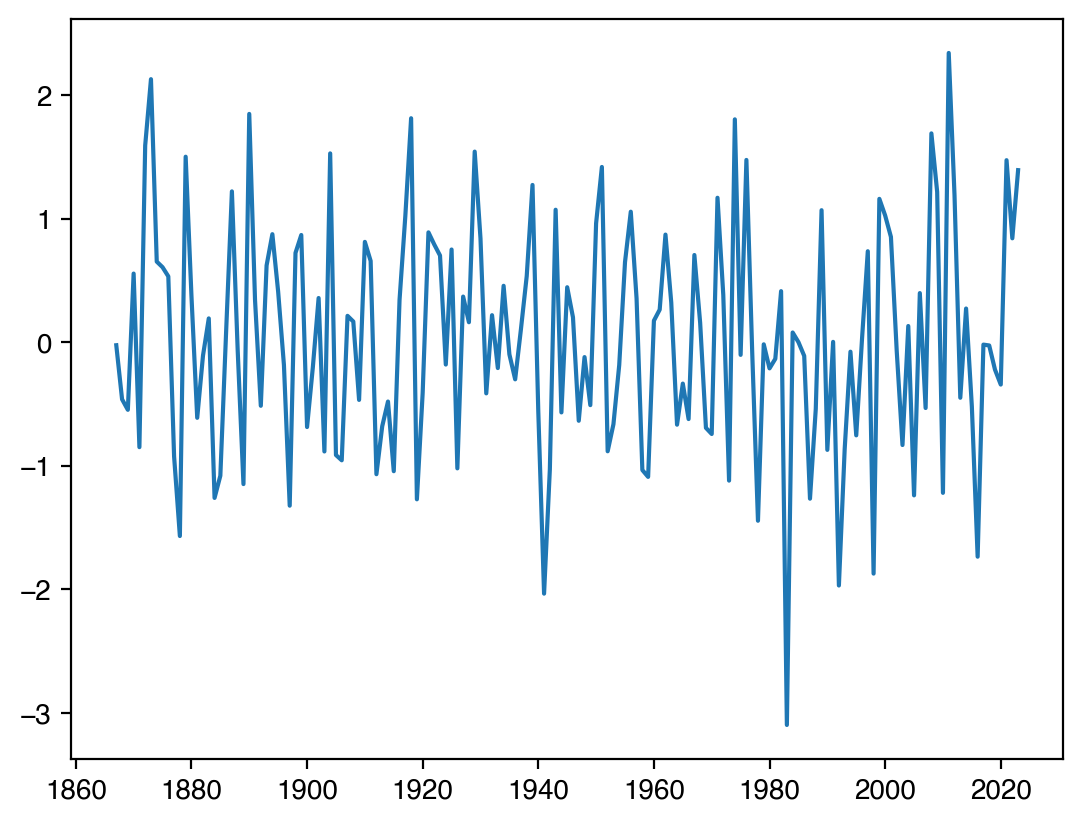

In [6]:
# Calculate the 3-month rolling mean - with min-periods=3, we won't get an empty year
soi_ = soi.rolling(time=3, min_periods=3).mean()

# Select February to get the 3-month average ending in February (i.e. DJF)
djf_soi = soi_[soi_.time.dt.month == 2]
soi_year = djf_soi.time.dt.year

# sanity check
plt.plot(soi_year, djf_soi)

Now, let's get out atmospheric pressure data.  For this example we'll use the 700 millibar geopotential height from the [20th Century Reanalysis](https://www.psl.noaa.gov/data/20thC_Rean/).  The height of the 700 millibar pressure surface is one that is often used to look at atmospheric teleconnections associated with ENSO.  We'll calculate a DJF average value everywhere for this field.  If you look at the time coordinate, you'll see it is _already_ a (very lengthy!) properly formatted `datetime64` type with year and month and a whole load of everything else down to the nanoseconds set to exactly midnight on the first day of the month (e.g. 1836-02-01T00:00:00.000000000), so once we get these data ready, we can go ahead and correlate with the SOI we worked on above.  

In [8]:
hgt = xr.open_dataset("hgt.700mb.mon.mean.nc")["hgt"]

# Calculate the 3-month rolling mean, again using min_periods=3 to require all 3 months exist
hgt_ = hgt.rolling(time=3, min_periods=3).mean()

# Select February to get DJF averages
djf_hgt = hgt_[hgt_.time.dt.month == 2]
djf_hgt = djf_hgt.squeeze(drop=True)  # this squeezes out (and drops) the singleton 'level' dimension
djf_hgt

<xarray.DataArray 'hgt' (time: 180, lat: 181, lon: 360)> Size: 47MB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[2693.867 , 2693.867 , 2693.867 , ..., 2693.867 , 2693.867 ,
         2693.867 ],
        [2691.8123, 2691.9326, 2692.052 , ..., 2691.4604, 2691.5754,
         2691.694 ],
        [2688.515 , 2688.8086, 2689.1006, ..., 2687.6335, 2687.9263,
         2688.2178],
...
        [2759.798 , 2759.9355, 2760.0713, ..., 2759.4016, 2759.5352,
         2759.665 ],
        [2760.801 , 2760.8665, 2760.9363, ..., 2760.5994, 2760.6667,
         2760.7334],
        [2762.9326, 2762.9326, 2762.9326, ..., 2762.9326, 2762.9326,
         2762.9326]],

       [[2660.0608, 2660.0608, 2660.0608, ..., 2660.0608, 2660.0608,
         2660.0608],
        [2656.6885, 2656.823 , 2656.9639, ..., 2656.286 , 2656.419 ,
         2656.553 ],
        [2653.4045, 2653.738 , 2654.07  , ..., 2652.405 , 2652.7346,
         2653.068 ],
        ...,
        [2700.6162, 2700.557 , 2700.5022, ..., 2700.8079, 2700.7434,
         2700.678 ],
        [2705.2346, 2705.1965, 2705.1604, ..., 2705.3577, 2705.3164,
         2705.275 ],
        [2710.4094, 2710.4094, 2710.4094, ..., 2710.4094, 2710.4094,
         2710.4094]]], shape=(180, 181, 360), dtype=float32)
Coordinates:
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1kB 1836-02-01 1837-02-01 ... 2015-02-01
Attributes: (12/15)
    long_name:         Monthly Geopotential Height on Pressure Levels
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             m
    GRIB_name:         HGT
    var_desc:          Geopotential height
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si-mo ...
    ...                ...
    standard_name:     geopotential_height
    valid_range:       [-1500. 60000.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ -307.88  50208.145]

Since our data are in the same temporal coordinate system, we can use xarray's correlation function (`xr.corr`) to calculate the correlation between the winter SOI and winter 700mb heights.  The SOI time series and the 700mb height field have the same *monthly* time coordinate formats, and xarray knows enough to match them up with one another for the correlation, even though the 700mb geopotential field has a lot more additional time units (seconds, nanoseconds, etc. )

In [9]:
# calculate the field correlation between the soi index and all the 700mb height data along the time dimension
fieldCorrelation = xr.corr(djf_soi,djf_hgt, dim="time")

# check - what does this look like in xarray DataArray format?
fieldCorrelation

<xarray.DataArray (lat: 181, lon: 360)> Size: 261kB
array([[-0.13888857, -0.13888857, -0.13888857, ..., -0.13888857,
        -0.13888857, -0.13888857],
       [-0.13365392, -0.1336867 , -0.13370734, ..., -0.13358387,
        -0.13361211, -0.13363594],
       [-0.13019964, -0.13025972, -0.13031916, ..., -0.13002424,
        -0.13007315, -0.13013563],
       ...,
       [-0.08071603, -0.08043182, -0.08014072, ..., -0.08161549,
        -0.08131111, -0.08101218],
       [-0.09160478, -0.09146111, -0.09132461, ..., -0.09203989,
        -0.09188555, -0.09174468],
       [-0.10259067, -0.10259067, -0.10259067, ..., -0.10259067,
        -0.10259067, -0.10259067]], shape=(181, 360), dtype=float32)
Coordinates:
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0

The variable `fieldCorrelation` is an xarray DataArray of Pearson correlation coefficients with the *latitude and longitude dimensions from the geopotential field!*.  The time coordinate has gone away, because what we're looking at here is the correlation between the DJF SOI time series and the time series of DJF 700 millibar heights at every point on the planet on a 1 degree grid.  It is a map.   

We could just plot this DataArray map of correlations now, actually.  However, when plotting global datasets (including this one), there is often a discontinuity where the longitudinal coordinate system wraps (either at 0 or at 180).  Since Cartopy is the mapping library, it is on it to handle this if it can.  At the moment, Cartopy includes a function to  wrap or add a cyclic point for seamless plotting.  It is a bit clunky in my view, as we have to (at least as far as I can tell?) essentially take our data our of DataArrays to do this (see more here: https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.util.add_cyclic_point.html).  Let's see how this works:

In [10]:
# pull out the function specifically here
from cartopy.util import add_cyclic_point

# also pull out the latitude and longitude, since adding the cyclic point seems alters the field correlation DataArray
field_lon = fieldCorrelation["lon"]
field_lat = fieldCorrelation["lat"]

# usually not necessary, but we can pass an index to the add_cyclic_point to tell it where the longitude coordinate is
idx_lon = fieldCorrelation.dims.index("lon")

# output two new Masked Arrays we can use for plotting 
field_wrap,field_wrap_lon = add_cyclic_point(fieldCorrelation.values,coord=field_lon,axis=idx_lon)

# you'll see the field is now 1 longitude until larger (361 instead of 360):
field_wrap.shape

(181, 361)

With the cyclic point added between the 360 and 0 degree longitude band, we can now go ahead and plot the global field correlation between SOI and 700mb heights:

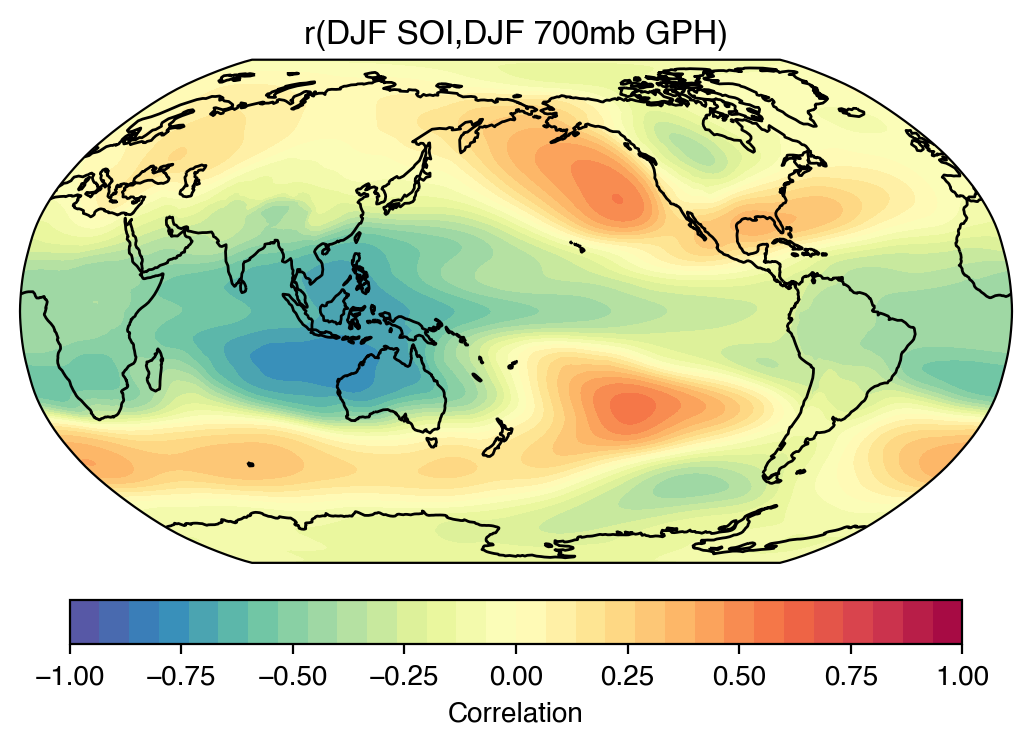

In [11]:
# plot the field correlations
fig, ax1 = plt.subplots(clear=True,nrows=1,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(field_wrap_lon,field_lat,field_wrap,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1, orientation='horizontal',location='bottom',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10) 

Just for fun, we can make a version where we also plot the locations where the two centers of action of the Southern Oscillation Index -- Tahiti and Darwin, Australia:

Text(130.8444, -16.4637, 'DARWIN')

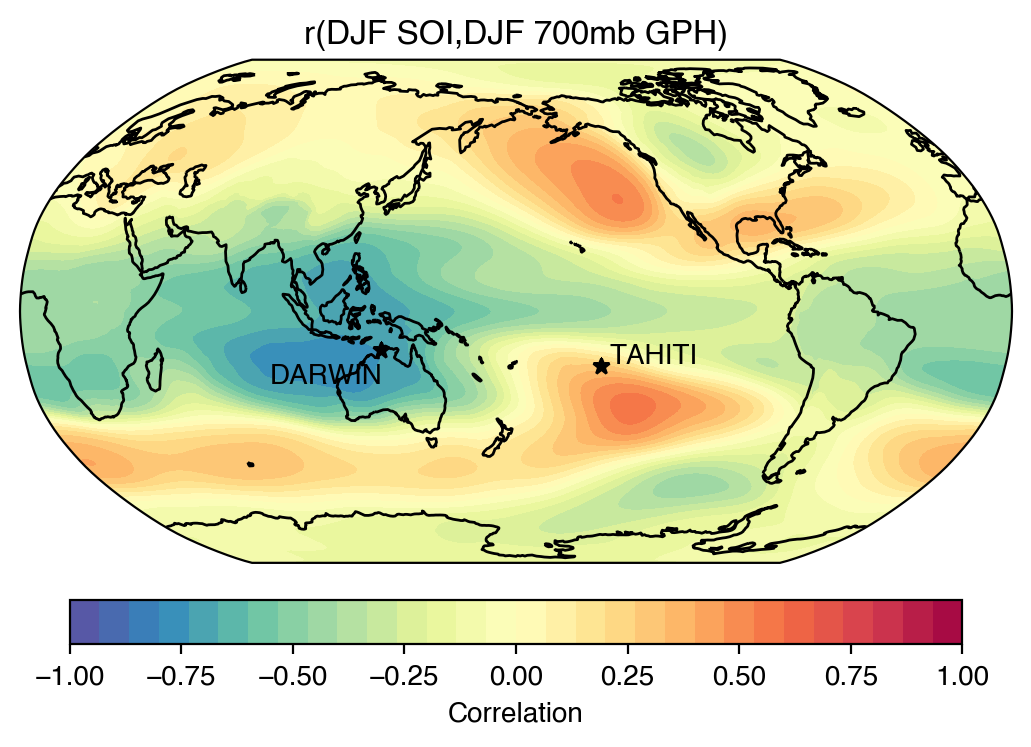

In [13]:
# geographic coordinates for the two poles of the SOI as dictionary types:
tahiti = dict(lon=211.4260, lat=-17.6509) 
darwin = dict(lon=130.8444, lat=-12.4637) 

# now plot the field correlations including the location of Tahiti and Darwin
fig, ax1 = plt.subplots(clear=True,nrows=1,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(field_wrap_lon,field_lat,field_wrap,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1, orientation='horizontal',location='bottom',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10) 

ax1.plot(tahiti["lon"],tahiti["lat"],'k*',transform=ccrs.PlateCarree())
ax1.plot(darwin["lon"],darwin["lat"],'k*',transform=ccrs.PlateCarree())
ax1.text(tahiti["lon"]+3, tahiti["lat"]+1, 'TAHITI', horizontalalignment='left', transform=ccrs.PlateCarree())
ax1.text(darwin['lon'], darwin['lat']-4, 'DARWIN', horizontalalignment='right',verticalalignment="top",transform=ccrs.PlateCarree())

There are other ways to calculate (and plot) the correlation between a single time series and the overlapping (in time) series from a spatial field.  But xarray provides really nice functionality for doing this, just as long as you can get both your time series and your field into DataArray formats *and* make sure the time coordinates have the same calendar and format. 

In the next notebook, we'll look at how to assess the potential significance of the patterns we see in spatial field correlations. 